###### <h1>Lecture 4, September 22, 2025 </h1>

 <h1> Estimation of ADL models </h1>

Marta Boczon

Department of Economics

Copnehagen Business School

mbo.eco@cbs.dk

In [1]:
install.packages("quantmod")
install.packages("fredr")
install.packages("ggfortify")
install.packages('urca')
install.packages("tseries")
install.packages("forecast")
install.packages("dynlm")
install.packages("stargazer")
install.packages("pracma")
install.packages("dLagM")
install.packages("gets")
install.packages("astsa")
options(warn=-1)


The downloaded binary packages are in
	/var/folders/nb/bcl7qtp16rv9lpgrryc9q4c00000gn/T//RtmpTTLFE4/downloaded_packages

The downloaded binary packages are in
	/var/folders/nb/bcl7qtp16rv9lpgrryc9q4c00000gn/T//RtmpTTLFE4/downloaded_packages

The downloaded binary packages are in
	/var/folders/nb/bcl7qtp16rv9lpgrryc9q4c00000gn/T//RtmpTTLFE4/downloaded_packages

The downloaded binary packages are in
	/var/folders/nb/bcl7qtp16rv9lpgrryc9q4c00000gn/T//RtmpTTLFE4/downloaded_packages

The downloaded binary packages are in
	/var/folders/nb/bcl7qtp16rv9lpgrryc9q4c00000gn/T//RtmpTTLFE4/downloaded_packages

The downloaded binary packages are in
	/var/folders/nb/bcl7qtp16rv9lpgrryc9q4c00000gn/T//RtmpTTLFE4/downloaded_packages

The downloaded binary packages are in
	/var/folders/nb/bcl7qtp16rv9lpgrryc9q4c00000gn/T//RtmpTTLFE4/downloaded_packages

The downloaded binary packages are in
	/var/folders/nb/bcl7qtp16rv9lpgrryc9q4c00000gn/T//RtmpTTLFE4/downloaded_packages

The downloaded binary packages 

Today we will continue to work with data on Canadian GDP we introduced last lecture:

1. **Data**: Canadian GDP (Real Gross Domestic Product for Canada)

2. **Source**: International Monetary Fund via FRED®

3. **Frequency**: Quarterly

4. **Units**: Millions of Domestic Currency

5. **Seasonal adjustment**: Seasonally Adjusted

https://fred.stlouisfed.org/series/NGDPRSAXDCCAQ

First, we will revisit whether ARIMA(0,0) — essentially white noise — is indeed the best fitting model. To do this, we will loop over multiple ARIMA specifications and compare them using the information criteria (AIC, BIC). This will allow us to see if any more complex model provides a significantly better fit.

Before we start the model comparison, however, we need to make sure our data is in the right form. That means importing the Canadian real GDP series and transforming it into a stationary process, building on what we learned last week about differencing and stationarity (see code below).

In [2]:
# Import the dataset from a CSV file downloaded from FRED
gdp =read.csv("NGDPRSAXDCCAQ.csv")
# Convert the second column of the dataset (the actual GDP values) into a time series object
tsgdp = ts(gdp[, 2], frequency = 4, start = c(1961, 1))
# Transform the series into (approximate) percentage changes
dgdp = diff(log(tsgdp))

# Fit ARIMA model with *auto.arima*

In [4]:
library(forecast)   # load the forecast package for auto.arima()

auto.arima(dgdp, 
           max.d = 0,    # no differencing allowed (series already made stationary)
           max.p = 4,    # maximum AR order (p)
           max.q = 4,    # maximum MA order (q)
           max.D = 0,    # no seasonal differencing
           max.P = 0,    # no seasonal AR terms
           max.Q = 0,    # no seasonal MA terms
           ic = "aic",   # choose the model that minimizes AIC
           stepwise = FALSE,     # search over all models (not just stepwise path)
           approximation = FALSE # use exact maximum likelihood (slower but more accurate)
)

# how many models from the family of ARIMA(p, q)? > (p=0..4)x(q=0..4)=5x5=25
# if we condisider subarima models, where coefficients can be or not be, then we jump to 2^(p+q) models. but this function does not consider this. the next section does.

Series: dgdp 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
        ar1      ma1    mean
      0.990  -0.9636  0.0080
s.e.  0.015   0.0240  0.0023

sigma^2 = 0.0001549:  log likelihood = 760.94
AIC=-1513.87   AICc=-1513.71   BIC=-1499.69

In [ ]:
library(forecast)   # load the forecast package for auto.arima()

auto.arima(dy, 
           max.d = 0,    # no differencing allowed (series already made stationary)
           max.p = 4,    # maximum AR order (p)
           max.q = 4,    # maximum MA order (q)
           max.D = 0,    # no seasonal differencing
           max.P = 0,    # no seasonal AR terms
           max.Q = 0,    # no seasonal MA terms
           ic = "bic",   # choose the model that minimizes BIC
           stepwise = FALSE,     # search over all models (not just stepwise path)
           approximation = FALSE # use exact maximum likelihood (slower but more accurate)
)

# *Auto.arima* behind the hood

In [ ]:
p = 4       # Maximum AR order
q = 4       # Maximum MA order
pq = (p+1) * (q+1)   # Total number of (p,q) combinations including 0
resAIC = rep(0, pq)  # Storage for AIC values
resBIC = rep(0, pq)  # Storage for BIC values
pdf = rep(0, pq)     # Storage for AR order (p)
qdf = rep(0, pq)     # Storage for MA order (q)

# if we condisider subarima models, where coefficients can be or not be, then we jump to 2^(p+q) models. but this function does not consider this. the next section does.

k = 0  # Counter for results
for (i in 0:p) {
    for (j in 0:q) {
        k = k + 1
        # Estimate ARMA(p,q) model for stationary series dy
        model = arima(dgdp, order = c(i,0,j))
        
        # Store information criteria
        resAIC[k] = AIC(model)
        resBIC[k] = BIC(model)
        
        # Store corresponding lag orders
        pdf[k] = i
        qdf[k] = j
    }
}

# Combine and display results: p, q, AIC, and BIC
results = cbind(pdf, qdf, data.frame(resAIC), data.frame(resBIC))
results 

# Find the model with the lowest AIC
bestAIC = results[which.min(results$resAIC), ]   # Row with min AIC

# Find the model with the lowest BIC
bestBIC = results[which.min(results$resBIC), ]   # Row with min BIC

# Display them
print("According to the AIC information criterion, the best model is")
bestAIC

print("According to the BIC information criterion, the best model is")
bestBIC

pdf,qdf,resAIC,resBIC
<dbl>,<dbl>,<dbl>,<dbl>
0,0,-1512.913,-1505.822
0,1,-1511.087,-1500.451
0,2,-1509.389,-1495.209
0,3,-1507.523,-1489.798
0,4,-1507.440,-1486.169
1,0,-1511.100,-1500.464
1,1,-1513.873,-1499.692
1,2,-1511.968,-1494.242
1,3,-1509.978,-1488.707


[1] "According to the AIC information criterion, the best model is"


,pdf,qdf,resAIC,resBIC
,<dbl>,<dbl>,<dbl>,<dbl>
7,1,1,-1513.873,-1499.692


[1] "According to the BIC information criterion, the best model is"


,pdf,qdf,resAIC,resBIC
,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,-1512.913,-1505.822


**Interpretation**:

The manual loop we implemented — where we estimated many ARMA(p,q) models and compared their AIC and BIC values — is essentially what the automatic selection procedure does under the hood. It systematically evaluates a range of models and then chooses the one that minimizes the chosen information criterion.

Because of this, it is not correct in a report or synopsis to simply state that ‘the best fitting model was chosen by auto.arima’. We need to know what the automatic procedure is doing and explain that process clearly. It means to avoid refering to R functions directly. Instead, we describe the model selection procedure in plain language:

1. What maximum lag orders (p and q) were allowed in the search.

2. Which information criterion was used for model comparison (AIC or BIC).

3. Whether the search considered all models exactly or followed a faster stepwise strategy.

4. Whether likelihood estimation was exact or approximate, and if approximate, how much time was saved.

In other words, we describe how the model was chosen under the hood rather than pointing to the function name. This shows our understanding of both the mechanics and the reasoning behind the selected model.

For example,



<div style="background-color:lightyellow; padding:10px; border-radius:5px;">
<p>
We evaluated autoregressive moving average (ARMA) models with up to 4 lags in both the autoregressive and moving average terms. This meant that a total of 25 models (all combinations of p = 0,…,4 and q = 0,…,4) were estimated. The choice of 4 lags reflects a balance between allowing enough dynamics to capture quarterly fluctuations in GDP and keeping the model space manageable for interpretation.
</p>    

<p>    
The models were compared using the Akaike Information Criterion (AIC), and the search considered all possible specifications within this range (an exact search rather than a stepwise approximation). Likelihood estimation was carried out without approximation. Based on this procedure, the ARMA(0,0) model, which corresponds to white noise, was selected as the best fitting model.
</p>    
</div>

# Find best-fitting subset-ARMA model using information criteria

*Auto.arima* automates model selection by fitting a grid of ARMA(p,q) candidates and choosing the one that minimizes an information criterion (typically AIC or BIC), often within user-set bounds (e.g., $p,q \leq 4 → 5\times 5 = 25$ models). Next, we move to a subset-ARMA search that is more flexible: instead of enforcing consecutive lags up to p and q, we allow selected lags only by fixing some coefficients to zero and estimating others. With four AR slots and four MA slots, each coefficient can be either fixed (0) or free (NA), giving 
$2^8=256$ possible specifications. We’ll evaluate each feasible spec (skipping non-estimable ones) and compare AIC/BIC—trading off fit and parsimony while revealing which specific lags (e.g., AR3, MA4) actually matter.

In [ ]:
##############################################
## Exhaustive ARIMA Subset Search with AIC/BIC
##############################################
p = 4                      # number of AR coefficients considered (AR(1) .. AR(4))
q = 4                      # number of MA coefficients considered (MA(1) .. MA(4))
pq = p + q                 # total number of non-seasonal AR and MA parameters

# Build a data frame of all 2^(p+q) combinations of {0, NA} for AR1..AR4 and MA1..MA4
# Each row is a pattern telling arima() which coefficients are fixed (0) vs free (NA).
indvar = do.call(expand.grid, replicate(pq, c(0, NA), simplify = FALSE))

## Give column names to aid interpretation (AR first, then MA)
colnames(indvar) = c("ar1","ar2","ar3","ar4","ma1","ma2","ma3","ma4")

res_list = list()          # container to store per-model results (AIC/BIC and names)

iter = 0  # Counter for results (row counter in res_list)

# Loop over every 0/NA pattern (i.e., every model specification)
for (i in 1:nrow(indvar)) {
        iter = iter + 1
        # Identify which AR/MA parameters are FREE under this pattern:
        # NA entries indicate parameters to estimate.
        active_idx  = which(is.na(indvar[i, ]))  # indices of NA among ar*/ma* slots
        
        # Map those indices for reporting.
        active_names = colnames(indvar)[active_idx]
        
        # Fit ARIMA(4,0,4) with this fixed pattern.
        # 'fixed' must contain AR1..AR4, MA1..MA4, and then the mean.
        # Appending NA at the end frees the intercept/mean in every spec.
        model = try(suppressWarnings(arima(dgdp, order = c(4,0,4), fixed =c(indvar[i,], NA))), silent = TRUE) # order = c(p,d,q), fixed = c(ar1, ar2, ar3, ar4, ma1, ma2, ma3, ma4, mean) (which is NA if we want to estimate it)
        
        # If estimation fails (e.g., non-invertible MA, singular information matrix),
        # skip this specification and continue to the next pattern.
        if (inherits(model, "try-error")) next     
        
        # Save a compact summary row:
        # - 'regressors' lists the FREE (estimated) AR/MA parameter names for this pattern
        # - AIC/BIC are the information criteria for model comparison
        res_list[[iter]] = data.frame(
         regressors = paste(active_names, collapse = " + "),
         AIC        = AIC(model),
         BIC        = BIC(model)
        )
}

## ---- 8) Bind results into a single data frame -----------------------------
# Stack all rows from res_list into a single data frame
results = do.call(rbind, res_list)

## Quick look at the first and last few rows of the results table
head(results)
tail(results)

## ---- 9) Identify the best models by AIC and BIC ---------------------------
# Find the row indices of the minimum AIC and BIC
best_by_AIC = results[which.min(results$AIC), ]
best_by_BIC = results[which.min(results$BIC), ]

## Display the best specs under each criterion
best_by_AIC
best_by_BIC

,regressors,AIC,BIC
,<chr>,<dbl>,<dbl>
1,,-1512.913,-1505.822
2,ar1,-1511.100,-1500.464
3,ar2,-1511.285,-1500.649
4,ar1 + ar2,-1509.462,-1495.281
5,ar3,-1511.130,-1500.494
6,ar1 + ar3,-1509.303,-1495.123


,regressors,AIC,BIC
,<chr>,<dbl>,<dbl>
250,ar2 + ar4 + ma1 + ma2 + ma3 + ma4,-1507.974,-1479.613
251,ar1 + ar2 + ar4 + ma1 + ma2 + ma3 + ma4,-1507.324,-1475.418
252,ar3 + ar4 + ma1 + ma2 + ma3 + ma4,-1508.496,-1480.135
253,ar1 + ar3 + ar4 + ma1 + ma2 + ma3 + ma4,-1506.500,-1474.593
254,ar2 + ar3 + ar4 + ma1 + ma2 + ma3 + ma4,-1509.232,-1477.326
255,ar1 + ar2 + ar3 + ar4 + ma1 + ma2 + ma3 + ma4,-1506.980,-1471.529


,regressors,AIC,BIC
,<chr>,<dbl>,<dbl>
196,ar3 + ma3 + ma4,-1515.354,-1497.628


,regressors,AIC,BIC
,<chr>,<dbl>,<dbl>
1,,-1512.913,-1505.822


**Subset-ARMA selection results.**  
Using the subset-ARMA search (256 specifications with selected lags allowed), the **BIC** criterion selected the **same model as before—white noise (ARMA(0,0))**, confirming our earlier conclusion that additional dynamics are not warranted once we penalize complexity strongly. In contrast, **AIC**—which penalizes extra parameters less—prefers a richer specification with **AR3 + MA3 + MA4**. In short: **BIC ⇒ white noise**, **AIC ⇒ AR3+MA3+MA4**.

In [ ]:
model = arima(dgdp, order = c(4,0,4), fixed=c(0, 0, NA, 0, 0, 0, NA, NA, NA))
stargazer(model, type = "text")


                      Dependent variable:    
                  ---------------------------
                             dgdp            
---------------------------------------------
ar1                          0.000           
                                             
                                             
ar2                          0.000           
                                             
                                             
ar3                        0.929***          
                            (0.037)          
                                             
ar4                          0.000           
                                             
                                             
ma1                          0.000           
                                             
                                             
ma2                          0.000           
                                             
                                 

# ARIMAX/ ADL models

**ARIMAX: Autoregressive Moving Average model with Explanatory Variable**


$$\color{blue}{y_t = a_0+\sum_{i=1}^p a_iy_{t-i}+\sum_{i=1}^q b_i\epsilon_{t-i}+\sum_{j=1}^r c_jz_{t-j} +\epsilon_t}, $$

where $y_t$ is the dependent variable, $y_{t-i}$ are its lagged values, $\epsilon_{t-i}$ are lagged error terms, $z_{t-j}$ are exogenous regressors with their lags, $a_i$, $b_i$, and $c_j$ are coefficients to be estimated, and $\epsilon_t$ is the white noise error term.

**Estimation**

The ARIMAX model cannot be estimated using OLS. Instead, one needs to use ML.

**ADL: Autoregressive Distributed Lag  model**



$$\color{blue}{y_t = a_0+\sum_{i=1}^p a_iy_{t-i}+\sum_{j=1}^r c_jz_{t-j} +\epsilon_t}, $$

where $y_t$ is the dependent variable, $y_{t-i}$ are its lagged values, $z_{t-j}$ are exogenous regressors with their lags, $a_i$ and $c_j$ are coefficients to be estimated, and $\epsilon_t$ is the white noise error term.

**Examples**:

<ol>
<li> $y_t=a_0+a_1y_{t-1}+\mathbf{c_0z_{t}} + \epsilon_t$   
<li> $y_t=a_0+a_1y_{t-1}+\mathbf{c_0z_{t}+c_1z_{t-1}} + \epsilon_t $   
<li> $y_t=a_0+a_1y_{t-1}+\mathbf{c_1z_{t-1}} + \epsilon_{t}$     
</ol>      
    
In an ADL model, if you include a contemporaneous regressor (say, $z_t$ on the right-hand side of $y_t$), then:

In theory, $z_t$ might be endogenous, because $z_t$ and $y_t$ could be determined simultaneously, or because both respond to the same shock in the error term $\epsilon_t$.

This means the OLS estimate of the coefficient on $z_t$ could be biased and inconsistent.

That’s why the classic ADL setup usually emphasizes lagged values of regressors ($z_{t-1}, z_{t-2}, …$). Using lags reduces the risk of contemporaneous feedback and makes it more plausible that the regressors are predetermined relative to $y_t$.  



**Contemporaneous Terms in ADL Models**

When specifying an ADL model, it may be tempting to include the contemporaneous value of a regressor (e.g. $x_t$ on the right-hand side of $y_t$).  

**Important rule:**  
- In general, we should **not include contemporaneous regressors** in an ADL model.  
- The reason is that $z_t$ may be **endogenous** — it might move together with $y_t$ because of common shocks or simultaneous determination. In this case, the error term $\epsilon_t$ is correlated with $z_t$, and OLS estimates will be biased and inconsistent.  

- If we believe the contemporaneous regressor is **strictly exogenous**, we must **argue clearly why**.  
- For example:  
  - If $z_t$ is a policy variable set independently of current GDP shocks (e.g., a predetermined tax rule).  
  - If $z_t$ reflects external conditions (e.g., world oil prices), where feedback from Canadian GDP is negligible.  
- In such cases, we can justify including $z_t$, but you must make the exogeneity assumption explicit.  


**Estimation**

The ADL model can be estimated using OLS.

# Empirical example

**Today’s lecture will focus on learning by doing with a real data example.  
We will estimate an ADL (Autoregressive Distributed Lag) model.** We will analyze whether **hours worked in the manufacturing sector in Canada** helps explain the **growth rates of Canadian GDP**.  



### Steps for Estimating an ADL Model (assuming stationarity)

A. Create a joint time series object of at least two stationary series of the same frequency.

B. Find the best fitting ADL model.  

C. Estimate the best fitting ADL model.  





Before we begin, we need to make sure all data are stationary.  
This requires revisiting the **Steps 1–5 from last week’s lecture**, now applied to the *Hours Worked* series:

1. **Import** the dataset into the software.  
2. **Create** a time series object.  
3. **Plot** the data to get an initial look at patterns.  
4. **Test** whether the series has a unit root.  
5. **Apply** transformations if necessary to remove non-stationarity, and then re-test.  


# Exercise

Download the data on hours worked and, following Steps 1–5 listed above, transform the series into a stationary dataset.

1. **Data**: Hours: Hours Worked: Manufacturing: Weekly for Canada (HOHWMN02CAM065N)

2. **Source**: Organization for Economic Co-operation and Development via FRED®

3. **Frequency**: Quarterly (aggregation method: Average)

4. **Units**: Hours

5. **Seasonal adjustment**: Not Seasonally Adjusted

https://fred.stlouisfed.org/series/HOHWMN02CAM065N


In [ ]:
hours = read.csv('HOHWMN02CAM065N.csv')

head(hours)

tail(hours)

colnames(hours)[2]

,observation_date,HOHWMN02CAM065N
,<chr>,<dbl>
1,1960-01-01,40.5
2,1960-04-01,40.3
3,1960-07-01,40.7
4,1960-10-01,40.0
5,1961-01-01,40.3
6,1961-04-01,40.7


,observation_date,HOHWMN02CAM065N
,<chr>,<dbl>
250,2022-04-01,36.8
251,2022-07-01,37.0
252,2022-10-01,36.9
253,2023-01-01,37.3
254,2023-04-01,37.5
255,2023-07-01,37.6


[1] "HOHWMN02CAM065N"

In [ ]:
ts_hours = ts(
    hours[, 2], 
    frequency = 4, 
    start = c(1960, 1), # starts in 1961 Q1
)

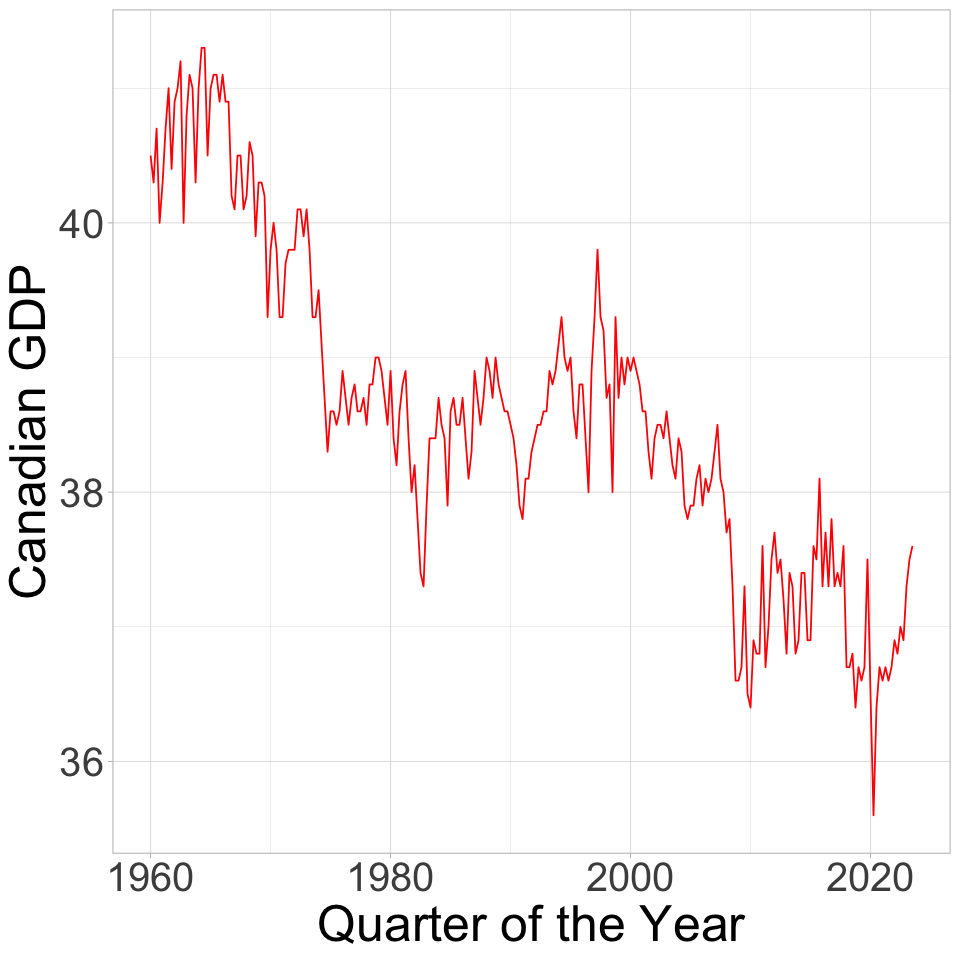

In [ ]:
# Load the ggplot2 package for plotting
library(ggplot2)

# Load ggfortify, which allows autoplot() to work directly with time series objects
library(ggfortify)

# Set default figure size for plots
options(repr.plot.width = 8, repr.plot.height = 8)

# Create a plot of the time series object 'tsdata' in red
fig = autoplot(ts_hours, colour = 'red')

# Customize the plot appearance
fig = fig + 
  theme(aspect.ratio = 1) +   # Keep a square aspect ratio
  theme_light() +             # Use a light background theme
  theme(plot.margin = ggplot2::margin(0.2, 0.2, 0.2, 0.2, "cm")) + # Adjust margins
  theme(text = element_text(size = 30)) + # Increase font size for readability
  labs(x = "Quarter of the Year") +          # Label the x-axis
  labs(y = "Canadian GDP")    # Label the y-axis

# Display the plot
fig


In [ ]:
# testing for a unit root
library(urca)
summary(ur.df(ts_hours, type = 'trend', lags = 8, selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.90865 -0.18990  0.02053  0.20121  1.04538 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  4.3057929  1.6595773   2.595  0.01007 * 
z.lag.1     -0.1076452  0.0409813  -2.627  0.00919 **
tt          -0.0013600  0.0006615  -2.056  0.04090 * 
z.diff.lag1 -0.1862935  0.0711183  -2.619  0.00938 **
z.diff.lag2 -0.2070523  0.0708395  -2.923  0.00381 **
z.diff.lag3 -0.1015793  0.0719109  -1.413  0.15910   
z.diff.lag4  0.1818924  0.0707114   2.572  0.01072 * 
z.diff.lag5 -0.0809457  0.0716118  -1.130  0.25949   
z.diff.lag6 -0.0050747  0.0702730  -0.072  0.94249   
z.diff.lag7 -0.1039312  0.0670651  -1.550  0.12256   
z.diff.lag8  0.1031624  0.0643336   1.604  0.11016   


we fail to reject the null hypothesis of phi2 that the trend is significant. Not the right specification. WE have to rerun the test without drift and deterministic component (phi2, phi3).

In [ ]:
summary(ur.df(ts_hours, type = 'drift', lags = 8, selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.92132 -0.20354  0.00453  0.20835  1.08986 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.13798    0.69084   1.647   0.1008    
z.lag.1     -0.03022    0.01791  -1.687   0.0928 .  
z.diff.lag1 -0.26124    0.06446  -4.053 6.87e-05 ***
z.diff.lag2 -0.26502    0.06674  -3.971 9.50e-05 ***
z.diff.lag3 -0.15999    0.06837  -2.340   0.0201 *  
z.diff.lag4  0.15666    0.06842   2.289   0.0229 *  
z.diff.lag5 -0.13817    0.06825  -2.025   0.0440 *  
z.diff.lag6 -0.06502    0.06606  -0.984   0.3260    
z.diff.lag7 -0.15710    0.06332  -2.481   0.0138 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3223 on 237 degrees of freed

we fail to reject the null hypothesis of phi1 that the drift is significant

In [ ]:
summary(ur.df(ts_hours, type = 'none', lags = 8, selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8648 -0.2042  0.0012  0.2149  1.0881 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -0.0007340  0.0005426  -1.353  0.17739    
z.diff.lag1 -0.2795002  0.0637327  -4.386 1.74e-05 ***
z.diff.lag2 -0.2802193  0.0663361  -4.224 3.42e-05 ***
z.diff.lag3 -0.1726109  0.0681863  -2.531  0.01200 *  
z.diff.lag4  0.1432734  0.0681844   2.101  0.03667 *  
z.diff.lag5 -0.1531833  0.0678833  -2.257  0.02494 *  
z.diff.lag6 -0.0759378  0.0659625  -1.151  0.25079    
z.diff.lag7 -0.1660033  0.0633163  -2.622  0.00931 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3235 on 238 degrees of freedom
Multiple R-squared:  0.2373,	Adjusted R-squ

we fail to reject the null hypothesis that the series has a unit root, thus the series is non-stationary.

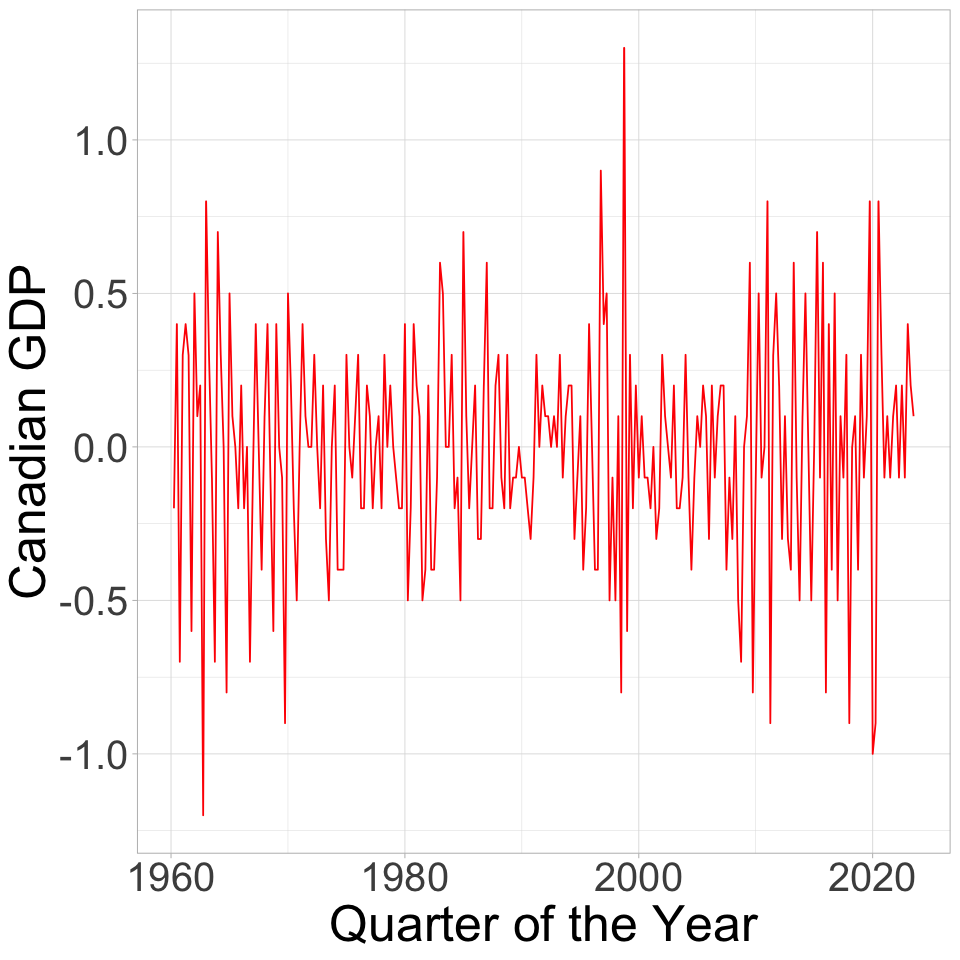

In [ ]:
dhours = diff(ts_hours)


# Load the ggplot2 package for plotting
library(ggplot2)

# Load ggfortify, which allows autoplot() to work directly with time series objects
library(ggfortify)

# Set default figure size for plots
options(repr.plot.width = 8, repr.plot.height = 8)

# Create a plot of the time series object 'tsdata' in red
fig = autoplot(dhours, colour = 'red')

# Customize the plot appearance
fig = fig + 
  theme(aspect.ratio = 1) +   # Keep a square aspect ratio
  theme_light() +             # Use a light background theme
  theme(plot.margin = ggplot2::margin(0.2, 0.2, 0.2, 0.2, "cm")) + # Adjust margins
  theme(text = element_text(size = 30)) + # Increase font size for readability
  labs(x = "Quarter of the Year") +          # Label the x-axis
  labs(y = "Canadian GDP")    # Label the y-axis

# Display the plot
fig


In [ ]:
# picking up on the last specification i.e. none
summary(ur.df(dhours, type = 'none', lags = 8, selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0247075 -0.0060607 -0.0005424  0.0048632  0.0274686 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -1.93454    0.25135  -7.696 3.72e-13 ***
z.diff.lag1  0.65695    0.23158   2.837  0.00495 ** 
z.diff.lag2  0.38093    0.20729   1.838  0.06736 .  
z.diff.lag3  0.22051    0.18154   1.215  0.22571    
z.diff.lag4  0.36221    0.14321   2.529  0.01208 *  
z.diff.lag5  0.22040    0.10357   2.128  0.03436 *  
z.diff.lag6  0.16338    0.06355   2.571  0.01075 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.008518 on 238 degrees of freedom
Multiple R-squared:  0.6838,	Adjusted R-squared:  0.6745 
F-statistic: 73.52 on 7 

we reject the null that the differenced series has a unit root, thus the differenced series is stationary.

#  ADL Step 1: Create a joint time series object

In [ ]:
# Create a joint time series object that combines GDP growth (dgdp) 
# and changes in hours worked (dhours), keeping only observations 
# where both series are available
data = ts.intersect(dgdp, dhours)

# Display the first few observations of the combined dataset
head(data)

# Display the last few observations of the combined dataset
tail(data)

,dgdp,dhours
1961 Q2,0.025005468,0.009876623
1961 Q3,0.024042802,0.007343974
1961 Q4,0.013513087,-0.014742282
1962 Q1,0.026262130,0.012300278
1962 Q2,0.007915743,0.002442004
1962 Q3,0.012708511,0.004866190


,dgdp,dhours
2022 Q2,0.010229149,-0.002713706
2022 Q3,0.005138201,0.005420067
2022 Q4,-0.001370987,-0.002706362
2023 Q1,0.013454326,0.010781776
2023 Q2,0.001425423,0.005347606
2023 Q3,-0.002258095,0.002663117


# ADL Step 2: Find best-fitting ADL model

In [ ]:
##############################################
## Exhaustive ADL Subset Search with AIC/BIC
##############################################

## ---- 0) Libraries ---------------------------------------------------------
## 'gets' provides the arx() function for regression with optional diagnostics.
library(gets)

## ---- 1) Create lagged variables ------------------------------------------
## Assume 'data' is a bivariate ts object: 
##   - column 1: y (e.g., GDP growth)
##   - column 2: x (e.g., ΔHours worked)
## We build up to 4 lags for each series.

y0 = data[, 1]                # y_t (dependent variable at time t)

# 4 lags of y (GDP) and x (Hours worked)

y1 = lag(data[, 1], -1)       # y_{t-1}
y2 = lag(data[, 1], -2)       # y_{t-2}
y3 = lag(data[, 1], -3)       # y_{t-3}
y4 = lag(data[, 1], -4)       # y_{t-4}

x1 = lag(data[, 2], -1)       # x_{t-1}
x2 = lag(data[, 2], -2)       # x_{t-2}
x3 = lag(data[, 2], -3)       # x_{t-3}
x4 = lag(data[, 2], -4)       # x_{t-4}

## ---- 2) Align sample (common time span) -----------------------------------
## ts.intersect keeps only the time points where all included series are observed.
## This ensures comparable samples across all model specifications.
tempdata = ts.intersect(
  y0,
  y1, y2, y3, y4,
  x1, x2, x3, x4
)

## ---- 3) Define dependent and regressor matrices ---------------------------
## depvar: y_t aligned to the intersection sample.
## indvar: matrix of candidate regressors (lags of y and x).
depvar = tempdata[, 1]
indvar = tempdata[, 2:ncol(tempdata)]
## Give column names to aid interpretation
colnames(indvar) = c("y1","y2","y3","y4","x1","x2","x3","x4")

## ---- 4) Initialize containers for results ---------------------------------
## We'll accumulate rows (one per model) in a list, then rbind at the end.
res_list = list()
iter = 0

## ---- 5) Define the model space --------------------------------------------
## We will try ALL non-empty subsets of the candidate regressors:
## sizes i = 1, 2, ..., kmax. 
## WARNING: This is 2^kmax - 1 models (grows quickly with kmax).
kmax = ncol(indvar)   # total number of available regressors
k = 1:kmax            # index set for regressors

## ---- 6) Exhaustive subset loop --------------------------------------------
## Outer loop over subset size i
for (i in 1:kmax) {
  
  ## All combinations (columns) of size i from the set {1, ..., kmax}.
  ## combn returns a matrix with i rows and choose(kmax, i) columns.
  ksets = combn(k, i)
  
  ## Inner loop over each specific combination of regressors of size i
  for (j in 1:ncol(ksets)) {
    iter = iter + 1
    
    ## Indices of regressors to include in this model
    regressors = ksets[, j]
    
    ## Fit the ADL variant via arx():
    ## - depvar is the dependent variable (y_t)
    ## - mxreg supplies *exogenous* regressors (here: lags of y and x treated as "xreg")
    ## - mc = TRUE includes an intercept
    model = try(suppressWarnings(arx(depvar, mxreg = indvar[, regressors], mc = TRUE)), silent = TRUE)
    
    # If estimation fails
    # skip this specification and continue to the next pattern.
    if (inherits(model, "try-error")) next                 
                
    ## ---- 7) Store information criteria and regressor labels ----------------
    res_list[[iter]] = data.frame(
      regressors = paste(colnames(indvar)[regressors], collapse = " + "),
      AIC        = AIC(model),
      BIC        = BIC(model)
    )
  }
}

## ---- 8) Bind results into a single data frame -----------------------------
results = do.call(rbind, res_list)

## Quick look at the first and last few rows of the results table
head(results)
tail(results)

## ---- 9) Identify the best models by AIC and BIC ---------------------------
best_by_AIC = results[which.min(results$AIC), ]
best_by_BIC = results[which.min(results$BIC), ]

## Display the best specs under each criterion
best_by_AIC
best_by_BIC


,regressors,AIC,BIC
,<chr>,<dbl>,<dbl>
1,y1,-1450.646,-1443.636
2,y2,-1450.769,-1443.758
3,y3,-1450.720,-1443.710
4,y4,-1452.254,-1445.243
5,x1,-1456.509,-1449.498
6,x2,-1454.777,-1447.766


,regressors,AIC,BIC
,<chr>,<dbl>,<dbl>
250,y1 + y2 + y3 + y4 + x2 + x3 + x4,-1445.081,-1417.039
251,y1 + y2 + y3 + x1 + x2 + x3 + x4,-1448.783,-1420.740
252,y1 + y2 + y4 + x1 + x2 + x3 + x4,-1449.866,-1421.823
253,y1 + y3 + y4 + x1 + x2 + x3 + x4,-1449.675,-1421.633
254,y2 + y3 + y4 + x1 + x2 + x3 + x4,-1449.852,-1421.810
255,y1 + y2 + y3 + y4 + x1 + x2 + x3 + x4,-1447.871,-1416.323


,regressors,AIC,BIC
,<chr>,<dbl>,<dbl>
32,x1 + x3,-1456.901,-1446.385


,regressors,AIC,BIC
,<chr>,<dbl>,<dbl>
5,x1,-1456.509,-1449.498


In this loop exercise, we first defined a **candidate set of regressors** (lags of GDP growth and lags of hours worked) and then **systematically examined every non-empty subset** of those candidates. For each subset, we estimated an ADL-style regression with a constant (no contemporaneous regressors to avoid endogeneity), and **recorded AIC and BIC**. We then **ranked all models** by each criterion to see the fit–parsimony trade-off,  and reported the **best specification under AIC and under BIC**. In our run, AIC favored a richer hours-lag structure (lags 1 and 3), while BIC favored the parsimonious variant (lag 1 only); The key takeaway is that we **explicitly searched** the space of plausible ADL regressors, documented the search limits (which lags were allowed), and justified the final pick using transparent, reproducible criteria.


# ADL Step 3: Estimate the model

In [ ]:
library(dynlm)
library(stargazer)
model.aic = dynlm(dgdp ~ L(dhours, c(1,3)), data)  # dgdp on dhours lags 1 & 3
model.bic = dynlm(dgdp ~ L(dhours, 1), data)       # dgdp on dhours lag 1

# How does the syntax work in general?
# m_ardl13 = dynlm(dgdp ~ L(dgdp, 1) + L(dhours, 1:3), data)          # ARDL(1,3)
# m_ardl31 = dynlm(dgdp ~ L(dgdp, 1:3) + L(dhours, 1), data)          # ARDL(3,1)
# m_ardl22 = dynlm(dgdp ~ L(dgdp, 1:2) + L(dhours, 1:2), data)        # ARDL(2,2)

stargazer(model.aic, model.bic, type = "text")     # print both models


                                Dependent variable:            
                    -------------------------------------------
                                       dgdp                    
                             (1)                   (2)         
---------------------------------------------------------------
L(dhours, c(1, 3))1        0.006**                             
                           (0.002)                             
                                                               
L(dhours, c(1, 3))3         0.004                              
                           (0.002)                             
                                                               
L(dhours, 1)                                     0.005**       
                                                 (0.002)       
                                                               
Constant                  0.008***              0.008***       
                           (0.001)     

**Interpretation:**
Because the left-hand side is \( \Delta \log(\text{GDP}_t) \), coefficients measure effects on the **quarterly GDP growth rate** (in **percentage points** when you multiply by 100).

- **Intercept ≈ 0.008**  
  → Average quarterly GDP growth is about **0.8%**.

**Model (1)**  
- \(L(\Delta \text{hours}, 1) = 0.006^{**}\)  
  → A **+1 hour** increase in weekly hours **from \(t-2\) to \(t-1\)** is **associated with +0.6 pp** higher GDP growth in quarter \(t\).  
- \(L(\Delta \text{hours}, 3) = 0.004\)  
  → **Not statistically significant** → do not interpret as an effect.

**Model (2)**  
- \(L(\Delta \text{hours}, 1) = 0.005^{**}\)  
  → A **+1 hour** increase **from \(t-2\) to \(t-1\)** is **associated with +0.5 pp** higher GDP growth in quarter \(t\).
 

%%shell

jupyter nbconvert --to html ///content/lecture_4.ipynb